## Part 1 - Exploratory Data Analysis

### 1.0. Libraries and data files
***

In [1]:
!apt-get update
# importing the necessary spark environment and getting jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop2.7'

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InR

In [2]:
# getting the data
!pip install -q wget
!pip install -q findspark
import wget
data_19 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_19_players.csv'
data_21 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_21_players.csv'
dataset_19 = wget.download(data_19)
dataset_21 = wget.download(data_21)

In [3]:
import findspark
findspark.init()
#findspark.find()
from pyspark.sql import SparkSession

### 1.1 Data Exploration
***

In [4]:
# importing the 'FIFA_19.csv' as a Spark dataframe
spark = SparkSession.builder.appName('FIFA_19').config('spark.sql.caseSensitive', 'true').getOrCreate()
sc = spark.sparkContext
# not including header as data while reading so the header value is made true
df_19 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_19_players.csv')
# caching the dataframe from faster processing when the number of operations grow later on this dataframe
df_19.persist()
df_19.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

In [5]:
# viewing the execution plan
df_19.select('*').explain(True)

== Parsed Logical Plan ==
'Project [*]
+- Relation[ID#16,Name#17,Age#18,Photo#19,Nationality#20,Flag#21,Overall#22,Potential#23,Club#24,Club Logo#25,value(M)#26,wage(K)#27,Special#28,Preferred Foot#29,International Reputation#30,Weak Foot#31,Skill Moves#32,Work Rate#33,Body Type#34,Real Face#35,Position#36,Jersey Number#37,Joined#38,Loaned From#39,... 40 more fields] csv

== Analyzed Logical Plan ==
ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall: int, Potential: int, Club: string, Club Logo: string, value(M): string, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, ... 40 more fields
Project [ID#16, Name#17, Age#18, Photo#19, Nationality#20, Flag#21, Overall#22, Potential#23, Club#24, Club Logo#25, value(M)#26, wage(K)#27, Special#28, Preferred F

In [6]:
df_21 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_21_players.csv')
df_21.persist()
df_21.show()

+---------+--------------------+-----------------+--------------------+---+----------+---------+---------+-----------+-------------------+--------------------+-----------+-------+---------+---------+--------+----------------+--------------+------------------------+---------+-----------+-------------+--------------------+---------+------------------+--------------------+-------------+------------------+-----------+----------+--------------------+---------------+--------------------+----+--------+-------+---------+---------+------+---------+-----------+----------+-----------+--------+--------------+--------------------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+---------

Merging the 2019 and 2021 dataframe to get the overall, potential, value in 2021 for every player.

In [7]:
# first renaming the id column in fifa 21 database same as the id column in fifa 19 database for merging later
df_21 = df_21.withColumnRenamed('sofifa_id','ID')
# joining the two dataframes on id and only merging overall, potential and value_eur to the fifa 19 database
df = df_19.join(df_21['ID','overall','potential','value_eur'], on=['ID'], how='left_outer')
df.persist()
df.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill

In [8]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- value(M): string (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)
 |-- Contract 

Splitting the dataset:

To avoid data leakage we split the data into training and test dataset (validation) from the beginning before performing any steps related to data manipulations.

In [9]:
train_df, validation_df = df.randomSplit([0.8, 0.2], seed=2020)
train_df.persist()
validation_df.persist()

DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall: int, Potential: int, Club: string, Club Logo: string, value(M): string, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, SlidingTackle: in

Dealing Missing Values:

In this stage, we examine the dataset to see the necessary operations required on data to ease our analysis. Based on the examination, we develop separate transformers that can perform data manipulation to output the data in a desired format.

In [10]:
# checking the missing values
from pyspark.sql.functions import count, col, when
from pyspark.sql import functions as F
null_values_count = train_df.select([count(when(F.isnull(cols), cols)).alias(cols) for cols in train_df.columns])
null_values_count.show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

In this analysis, the attributes that we are concerned with are player attributes that has impacts on players' gameplay such as 'Crossing', ShortPassing', etc. We are only concerned with forwards, midfielders and defenders not goalkeepers. It is seen that all attributes of interests have 33 missing values which include goalkeeping attributes too. So, we need to see if those missing values for different attributes belong to goalkeepers only before performing imputation or deletion of missing values.

In [11]:
# checking the missing values after removing goalkeepers
df_non_goalkeeper = train_df.filter(train_df['Position'] != 'GK')
df_non_goalkeeper.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df_non_goalkeeper.columns]).show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

It is seen that no missing values are present in our many attributes of interests for players belonging to positions other than goalkeepers. Important features in our analysis such as value(M), potential and value_eur, still have missing values, so appropriate operations to deal with those missing values should be performed before we proceed to other analysis.

Handling of missing values in value(M) column:

In [12]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

#df_view = 'soccer_analysis'
train_df.createOrReplaceTempView('soccer_analysis')

In [13]:
spark.sql("""
          Select * from soccer_analysis Where value_eur Is Not Null AND `value(M)` Is Null
          """).show()

+------+---------------+---+--------------------+------------+--------------------+-------+---------+---------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|           Name|Age|               Photo| Nationality|                Flag|Overall|Potential|           Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|    

It is seen that although we have missing values for players value in 2019, we can find the value of some of those players in 2021. Based on the value in 2021, we perform imputation of missing values in value column in 2019. To do that, we first compare the values in both years and calculate the percentage variation in values in those two years. Using that variation, we calculate the figures for missing values. 

The necessary operation is performed in a separate python file which we will import later.

In [14]:
spark.sql("""
          Select * from soccer_analysis Where `value(M)` Like '%K'
          """).show()

+-----+---------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|   ID|           Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak

All the issues seen above have to be dealt before proceeding to further analysis. To deal with those issues, a separate python script has been developed which we will import later on in this analysis to create dataframes that are free from complications seen above.

Creating Pipelines for Data Preprocessing:

In this stage, we create a pipelines for the regression task. 

Note: the modules used to generate the regression dataframe can be found in the github repository for this project.

Here, we import two python scripts containing transformers that we developed according to our examination in the previous section. The first python script is data_preprocessor.py which contains classes such as ValueManipulator, UnifyValue and ValueImputer. The second script is target_generator, and it contains classes such as ProfitGenerator and GrowthGenerator.

In [15]:
!rm -rf FIFA_2019

In [15]:
# only for google colab
!git clone https://github.com/Gooner12/FIFA_2019.git FIFA_2019
!mv "/content/FIFA_2019/data_preprocessor.py" "/content/"
!mv "/content/FIFA_2019/target_generator.py" "/content/"

Cloning into 'FIFA_2019'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 296 (delta 166), reused 197 (delta 105), pack-reused 0
Receiving objects: 100% (296/296), 5.05 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (166/166), done.


In [16]:
from pyspark.ml import Pipeline
import data_preprocessor, target_generator

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor.UnifyValue()
# defining the stage that imputes and removes missing values present in players' values in 2019 and 2021
value_imputation = data_preprocessor.ValueImputer()
# defining the stage that generates labels based on profits in two years for regression
regression_target = target_generator.ProfitGenerator()

DataFrame for Regression:

In [17]:
# creating a pipeline to generate dataframe for regression
pipeline_regression = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, regression_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model = pipeline_regression.fit(train_df)
regression_df = pipeline_model.transform(train_df)
regression_df.persist()

The age bracket 1 has average variation of 1.725152
The age bracket 2 has average variation of 0.545784
The age bracket 3 has average variation of -0.032275
The age bracket 4 has average variation of -0.170250
The age bracket 5 has average variation of -0.260001
The age bracket 6 has average variation of 0.000000


DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall_2019: int, Potential_2019: int, Club: string, Club Logo: string, Value_2019(M): double, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, Sl

We record the above variations for each age group and use those values to impute missing values for the test dataset.

In [18]:
regression_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall_2019: integer (nullable = true)
 |-- Potential_2019: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value_2019(M): double (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)

In [19]:
regression_df.show(5)

+-----+-----------------+---+--------------------+-----------+--------------------+------------+--------------+---------------+--------------------+------------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-------------------+
|   ID|             Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|           Club|           Club Logo|     Value_2019(M)|wage(K)

In [20]:
# checking the missing values in regression dataframe
regression_df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in regression_df.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Un

It is seen that the column wage has 62 missing values, and this column might be important in predicting the players' price. 

In [21]:
# creating a view
regression_df.createOrReplaceTempView('soccer_analysis2')

# selecting the records containing null values in the wage column
spark.sql("""
          Select * from soccer_analysis2 Where `wage(K)` Is Null
          """).show()

+------+-----------------+---+--------------------+------------+--------------------+------------+--------------+----+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-------------------+
|    ID|             Name|Age|               Photo| Nationality|                Flag|Overall_2019|Potential_2019|Club|           Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|Internation

In [22]:
# finding the maximum value of a player whose wage is not disclosed
spark.sql("""
          Select MAX(`Value_2019(M)`), MIN(`Value_2019(M)`), MAX(Age), Min(Age) from soccer_analysis2 Where `wage(K)` Is Null
          """).show()

+------------------+------------------+--------+--------+
|max(Value_2019(M))|min(Value_2019(M))|max(Age)|min(Age)|
+------------------+------------------+--------+--------+
|             6.717|               0.0|      38|      18|
+------------------+------------------+--------+--------+



It is seen that the players whose wages are not disclosed are low value players ranging between 0 and 10 million. This might occur due to numerous reasons such as some players are just starting their professional football, some are at the end of their career or some are not good enough to negotiate their wage. These all reasons might led the players to accept the price their club has offered which is usually minimum wage. Thus, we impute the missing wage with the minimum wage amount.

In [23]:
# selecting the minimum wage
spark.sql("""
          Select MIN(`wage(K)`) from soccer_analysis2 Where `wage(K)` Is Not Null
          """).show()

+------------+
|min(wage(K))|
+------------+
|           1|
+------------+



In [24]:
# imputing the missing wage values with one
regression_df = regression_df.fillna(1, subset=['wage(K)'])
regression_df.persist()

DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall_2019: int, Potential_2019: int, Club: string, Club Logo: string, Value_2019(M): double, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, Sl

In [25]:
# checking the missing values in regression dataframe
regression_df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in regression_df.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Un

In [26]:
regression_df.select(['Value_2019(M)', 'Value_2021(M)']).show(5)

+------------------+-------------+
|     Value_2019(M)|Value_2021(M)|
+------------------+-------------+
|              21.5|          5.5|
| 3.200000047683716|        0.975|
|1.7999999523162842|         0.65|
|              15.5|          4.2|
|              77.0|         46.0|
+------------------+-------------+
only showing top 5 rows



Data Visualisation:

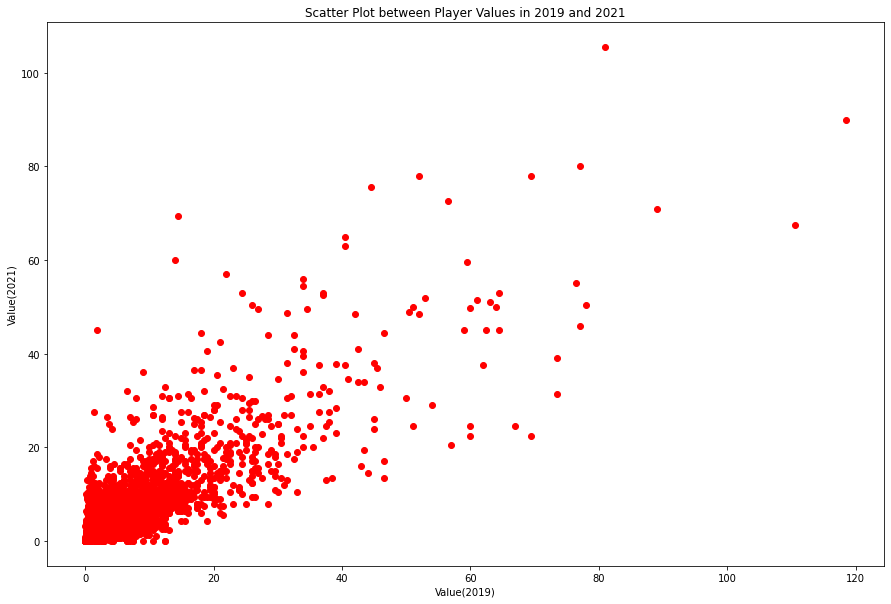

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

pd_df = regression_df.toPandas()

# plotting a scatter plot to see the realtionship between player values in 2019 and 2021
fig = plt.figure(figsize=(15,10))
plt.scatter(pd_df['Value_2019(M)'], pd_df['Value_2021(M)'], color='r')
plt.xlabel('Value(2019)')
plt.ylabel('Value(2021)')
plt.title('Scatter Plot between Player Values in 2019 and 2021')
plt.show()

Observing the distribution of variables:

There is a linear relationship between values in two years, and we can see some anomalies as well. Those anomalies are due to some players who have grown rapidly in the two year period causing their values to rise quickly. In our analysis, we are keeping those anomalies.

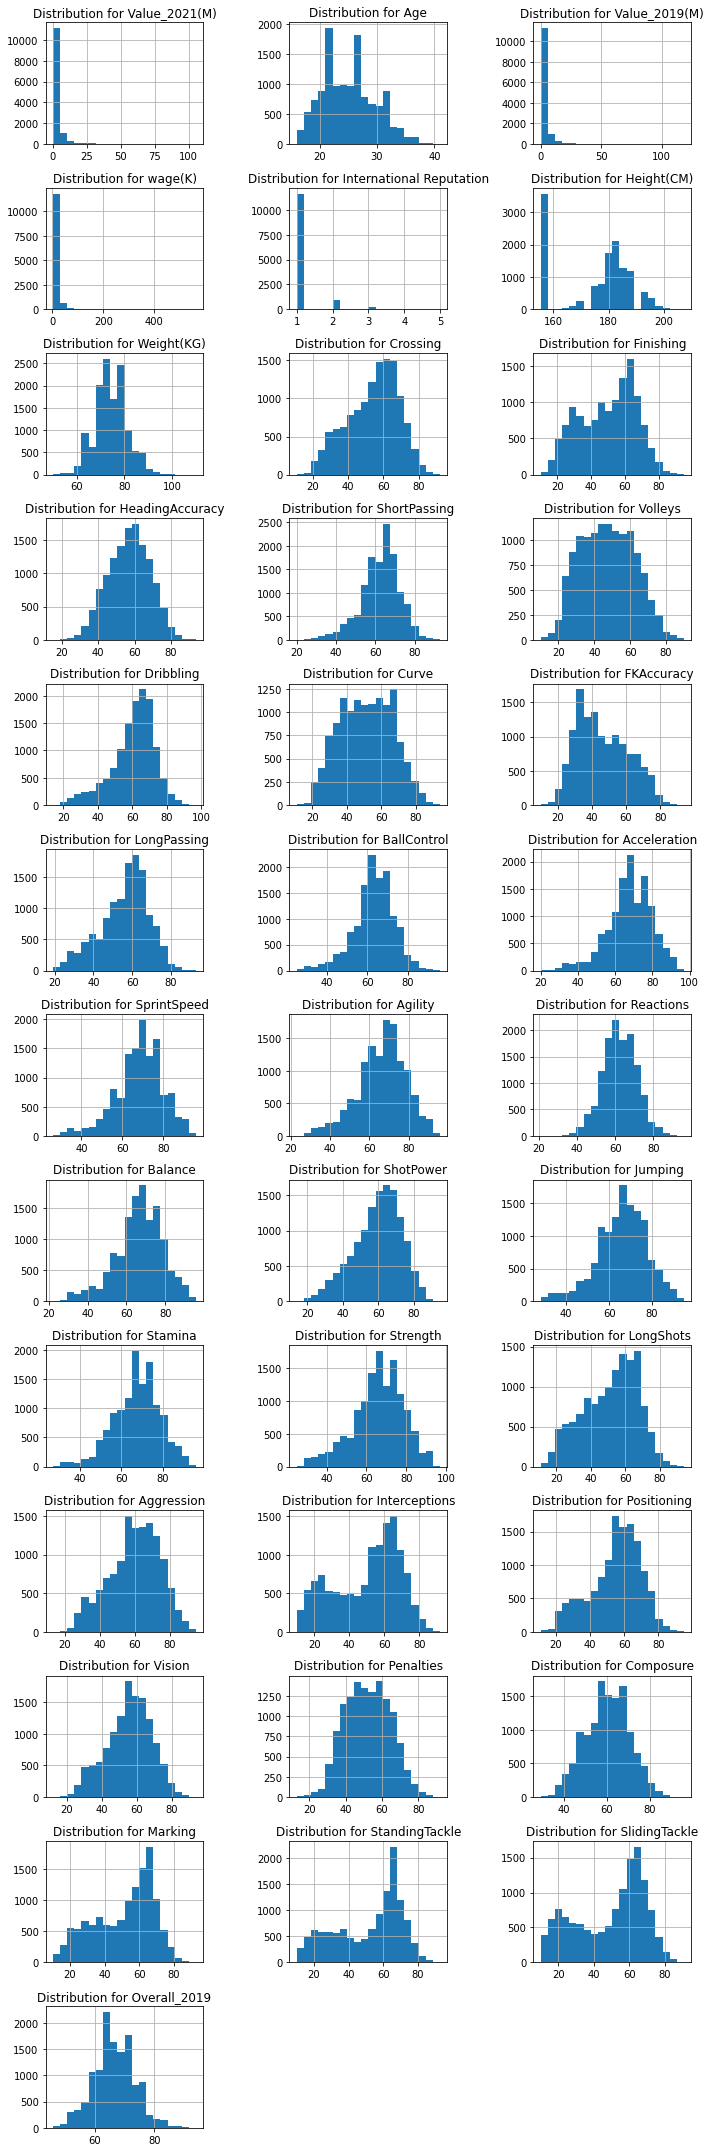

In [28]:
# selecting only the relevant numerical features to construct a histogram
features_col = [ 'Value_2021(M)', 'Age', 'Value_2019(M)', 'wage(K)', 'International Reputation', 'Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Overall_2019']

# defining a function that plots histograms
def distribution(df, rows, cols, width, height):
  fig = plt.figure(figsize=(width,height))
  for i, col in enumerate(df):
    ax = fig.add_subplot(rows, cols, i+1)
    df.hist(column=col, ax=ax, bins=20)
    ax.set_title('Distribution for '+col)

  fig.tight_layout()  
  plt.show()

distribution(pd_df[features_col], int(len(features_col)/3)+1, 3, 10, 30)

From the above distributions of different columns, it is seen that out of all columns 'Value_2021(M)', 'Value_2019(M)', 'wage(K)' and 'International Reputation' are not normally distributed. Other columns displayed some skewness but are close to being normally distributed.  

Also, the international reputation column is not continuous. It is categorical data (ordinal). We need to perform some encoding before fitting a linear regression model. For remaining non-normal attributes, we need to take some actions but only after fitting the linear regression first.

### 3.1 Data Preparation

We try to predict the value of players in two years using the attributes that might impact players' price tags and values.
***

Dummy Encoding:

In this step, we encode International Reputation which is ordinal data.

In [29]:
import pyspark.sql.functions as F 

def dummy_encoder(df):
  # getting the distinct ordinal values
  category = df.select('International Reputation').distinct().rdd.flatMap(lambda x:x).collect()
  # creating dummy encoded columns excluding one level
  exprs = [F.when(F.col('International Reputation') == cat, 1).otherwise(0)\
              .alias('International Reputation_'+ str(cat)) for cat in category[:-1]]
  df = df.select(exprs + df.columns)
  return df
  
regression_df = dummy_encoder(regression_df)
regression_df.show(5)

+--------------------------+--------------------------+--------------------------+--------------------------+-----+-----------------+---+--------------------+-----------+--------------------+------------+--------------+---------------+--------------------+------------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-------------------+
|International Reputation_1|International Reputation_3|Internation

Feature Engineering:

In this step, we try to find the features that are most correlated with the target (Gain in Two Years). From this step, we will only pick up those attributes who have at least of 10% correlation with the target whether negative or positive. We use both spearman and pearson correlation to determine this. Any attribute that pass this criterion on any of those two tests will be accepted into the next step.

In [30]:
from pyspark.ml.feature import VectorAssembler

features_col = ['Value_2021(M)', 'Age', 'Value_2019(M)', 'wage(K)', 'International Reputation_1', 'International Reputation_3',
                'International Reputation_4', 'International Reputation_5', 'Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Overall_2019']

vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
df_class = vec_assembler.transform(regression_df).select('features')
df_class.show(5)

+--------------------+
|            features|
+--------------------+
|[5.5,34.0,21.5,21...|
|[0.975,34.0,3.200...|
|[0.65,32.0,1.7999...|
|[4.2,34.0,15.5,80...|
|[46.0,33.0,77.0,4...|
+--------------------+
only showing top 5 rows



In [31]:
regression_df[features_col].show(5)

+-------------+---+------------------+-------+--------------------------+--------------------------+--------------------------+--------------------------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+------------+
|Value_2021(M)|Age|     Value_2019(M)|wage(K)|International Reputation_1|International Reputation_3|International Reputation_4|International Reputation_5|Height(CM)|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Volleys|Dribbling|Curve|FKAccuracy|LongPassing|BallControl|Acceleration|SprintSpeed|Agility|Reactions|Balance|ShotPower|Jumping|Stamina|Strength|LongShots|Aggression|Interceptions|Positioning|Vision|Penalties|Composure|Marking|StandingTackle|SlidingTackle|Overall_2019|
+-----------

In [ ]:
from pyspark.ml.stat import Correlation
#r1 = Correlation.corr(df_class, 'features', method='pearson').head()
pearson_corr = Correlation.corr(df_class, 'features', 'pearson').collect()[0][0]
print(str(pearson_corr))
#print('Pearson correlation matrix:\n' + str(r1[0]))

DenseMatrix([[ 1.        , -0.02934086,  0.85460062, ...,  0.08321708,
               0.06385752,  0.56292012],
             [-0.02934086,  1.        ,  0.08252199, ...,  0.21033237,
               0.17942919,  0.45383611],
             [ 0.85460062,  0.08252199,  1.        , ...,  0.09384732,
               0.06659134,  0.64133327],
             ...,
             [ 0.08321708,  0.21033237,  0.09384732, ...,  1.        ,
               0.9663477 ,  0.26372863],
             [ 0.06385752,  0.17942919,  0.06659134, ...,  0.9663477 ,
               1.        ,  0.22098014],
             [ 0.56292012,  0.45383611,  0.64133327, ...,  0.26372863,
               0.22098014,  1.        ]])


In [ ]:
# alternative way to calculate pearson correlation
import six
for i in regression_df[features_col].columns:
  # checking if the instance is of string type and using six to write compatible code for both python2.x and 3.x
  if not(isinstance(regression_df[features_col].select(i).take(1)[0][0], six.string_types)):
    print('Correlation to Value_2021(M) for ', i, regression_df[features_col].stat.corr('Value_2021(M)',i, 'pearson'))

Correlation to Value_2021(M) for  Value_2021(M) 1.0
Correlation to Value_2021(M) for  Age -0.029340856849072203
Correlation to Value_2021(M) for  Value_2019(M) 0.8546006157224946
Correlation to Value_2021(M) for  wage(K) 0.680846588633413
Correlation to Value_2021(M) for  International Reputation_1 -0.4187139957711144
Correlation to Value_2021(M) for  International Reputation_3 0.37716755665744384
Correlation to Value_2021(M) for  International Reputation_4 0.21679322293127834
Correlation to Value_2021(M) for  International Reputation_5 0.16746035909004206
Correlation to Value_2021(M) for  Height(CM) 0.0195060239123404
Correlation to Value_2021(M) for  Weight(KG) 0.03099685734877804
Correlation to Value_2021(M) for  Crossing 0.28743651422499134
Correlation to Value_2021(M) for  Finishing 0.2637731577390948
Correlation to Value_2021(M) for  HeadingAccuracy 0.18980982632812496
Correlation to Value_2021(M) for  ShortPassing 0.41475269062889875
Correlation to Value_2021(M) for  Volleys 0.2

In [ ]:
# creating a datafame from the dense matrix
import pandas as pd

labels = features_col 
#creating a dataframe from the dense matrix
pearson_df = pd.DataFrame(pearson_corr.toArray(), index = [i for i in labels], columns = [i for i in labels])
pearson_df

,Value_2021(M),Age,Value_2019(M),wage(K),International Reputation_1,International Reputation_3,International Reputation_4,International Reputation_5,Height(CM),Weight(KG),Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Overall_2019
Value_2021(M),1.000000,-0.029341,0.854601,0.680847,-0.418714,0.377168,0.216793,0.167460,0.019506,0.030997,0.287437,0.263773,0.189810,0.414753,0.286178,0.367742,0.308092,0.254936,0.306699,0.442918,0.201353,0.209651,0.197619,0.484521,0.110897,0.309578,0.078525,0.240458,0.079928,0.289784,0.153093,0.107427,0.295962,0.338861,0.226464,0.432045,0.103123,0.083217,0.063858,0.562920
Age,-0.029341,1.000000,0.082522,0.146249,-0.270092,0.105360,0.059764,0.025340,0.038594,0.215011,0.263349,0.143272,0.345351,0.307423,0.240938,0.103124,0.254136,0.302939,0.305683,0.250400,-0.209303,-0.203642,-0.016106,0.452994,-0.092406,0.304297,0.187992,0.226229,0.357421,0.271750,0.400122,0.282108,0.188270,0.237577,0.250366,0.462302,0.235847,0.210332,0.179429,0.453836
Value_2019(M),0.854601,0.082522,1.000000,0.851186,-0.531886,0.450618,0.348799,0.240506,0.029326,0.064959,0.309579,0.300053,0.243947,0.461370,0.343286,0.387082,0.345728,0.304055,0.350689,0.483537,0.176240,0.179804,0.197542,0.557508,0.104540,0.358406,0.106165,0.260649,0.120876,0.337237,0.196205,0.128227,0.330831,0.381390,0.281630,0.504069,0.119265,0.093847,0.066591,0.641333
wage(K),0.680847,0.146249,0.851186,1.000000,-0.529703,0.422939,0.403001,0.243950,0.036264,0.083137,0.289348,0.248871,0.255537,0.413443,0.303565,0.333343,0.309802,0.265636,0.318940,0.428370,0.114620,0.123595,0.152421,0.506937,0.077150,0.329153,0.118185,0.215762,0.134223,0.298707,0.215117,0.154729,0.286299,0.331714,0.257135,0.461964,0.141114,0.124402,0.103695,0.579739
International Reputation_1,-0.418714,-0.270092,-0.531886,-0.529703,1.000000,-0.403782,-0.164110,-0.055412,-0.030598,-0.097990,-0.268206,-0.216364,-0.249225,-0.365266,-0.308479,-0.273293,-0.307786,-0.279644,-0.301245,-0.364931,-0.010399,-0.004902,-0.087386,-0.449026,-0.041406,-0.325200,-0.107369,-0.115991,-0.132969,-0.284031,-0.228018,-0.154443,-0.251545,-0.307322,-0.280391,-0.439367,-0.142135,-0.119469,-0.096277,-0.491833
International Reputation_3,0.377168,0.105360,0.450618,0.422939,-0.403782,1.000000,-0.006728,-0.002272,0.017070,0.028405,0.137176,0.129200,0.116700,0.201932,0.172774,0.166593,0.160493,0.140895,0.154120,0.206799,0.043834,0.043038,0.068387,0.250037,0.041607,0.157719,0.052752,0.081660,0.051447,0.146191,0.092674,0.066387,0.143298,0.172868,0.152352,0.241892,0.063356,0.047597,0.035732,0.281417
International Reputation_4,0.216793,0.059764,0.348799,0.403001,-0.164110,-0.006728,1.000000,-0.000923,0.017336,0.033331,0.073769,0.066128,0.071904,0.099580,0.094884,0.073356,0.086053,0.083975,0.082349,0.106541,0.016461,0.015869,0.036581,0.130124,0.017146,0.083164,0.031575,0.036636,0.038925,0.077358,0.049168,0.036346,0.069783,0.092533,0.091222,0.122098,0.035634,0.026303,0.023667,0.151685
International Reputation_5,0.167460,0.025340,0.240506,0.243950,-0.055412,-0.002272,-0.000923,1.000000,0.012923,0.013151,0.032295,0.043824,0.028749,0.037619,0.046645,0.041436,0.040530,0.044982,0.032198,0.051238,0.022643,0.020705,0.029855,0.059394,0.007903,0.037340,0.010617,0.012939,0.003208,0.040806,0.003788,-0.022155,0.043275,0.041181,0.042952,0.058221,-0.022906,-0.020124,-0.021214,0.064232
Height(CM),0.019506,0.038594,0.029326,0.036264,-0.030598,0.017070,0.017336,0.012923,1.000000,0.390681,-0.253301,-0.142911,0.295034,-0.094349,-0.121377,-0.237387,-0.202286,-0.172704,-0.095211,-0.143066,-0.296088,-0.221693,-0.341645,0.010931,-0.430465,-0.041346,0.021042,-0.054765,0.346157,-0.147534,0.141279,0.091106,-0.203153,-0.190138,-0.104397,0.025425,0.106027,0.105326,0.087549,0.064847
Weight(KG),0.030997,0.215011,0.

Attributes that fail to satisfy the criterion from the pearson test are height(cm), weight(kg), age,  jumping, strength, standing tackle and sliding tackle.

In [ ]:
# creating a dataframe based on the spearman correlation
spearman_corr = Correlation.corr(df_class, 'features', 'spearman').collect()[0][0]
spearman_df = pd.DataFrame(spearman_corr.toArray(), index = [i for i in labels], columns = [i for i in labels])
spearman_df

,Value_2021(M),Age,Value_2019(M),wage(K),International Reputation_1,International Reputation_3,International Reputation_4,International Reputation_5,Height(CM),Weight(KG),Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Overall_2019
Value_2021(M),1.000000,-0.037896,0.851381,0.616626,-0.319997,0.183034,0.083014,0.029638,0.022542,0.041015,0.389117,0.338126,0.264236,0.569650,0.339326,0.544547,0.385887,0.303722,0.422148,0.627895,0.282627,0.303412,0.279664,0.590204,0.130946,0.438079,0.114295,0.322464,0.121237,0.400519,0.221021,0.197822,0.410158,0.420901,0.285645,0.537446,0.173341,0.184747,0.155413,0.733979
Age,-0.037896,1.000000,0.226539,0.330895,-0.263030,0.105025,0.059470,0.021945,0.059256,0.224728,0.287254,0.156078,0.361312,0.309974,0.248133,0.137861,0.265109,0.299758,0.312604,0.262030,-0.133288,-0.117972,0.025354,0.477566,-0.075417,0.338072,0.233972,0.292634,0.376328,0.301937,0.419010,0.313031,0.237241,0.256551,0.246844,0.469212,0.266230,0.250103,0.220834,0.478293
Value_2019(M),0.851381,0.226539,1.000000,0.770595,-0.388410,0.197689,0.087096,0.030104,0.053977,0.120335,0.474962,0.417826,0.388138,0.690943,0.439639,0.616331,0.483920,0.403858,0.533295,0.742257,0.262819,0.284914,0.312476,0.767050,0.114023,0.575148,0.199292,0.433165,0.254072,0.519600,0.356125,0.284702,0.516567,0.534300,0.373296,0.717735,0.247502,0.248244,0.203678,0.936279
wage(K),0.616626,0.330895,0.770595,1.000000,-0.399048,0.196472,0.087133,0.028240,0.055790,0.122165,0.418636,0.339682,0.379609,0.576199,0.388301,0.493765,0.424794,0.358626,0.452989,0.611140,0.134516,0.154332,0.218190,0.667558,0.063630,0.499289,0.194229,0.325060,0.256203,0.443531,0.351494,0.275548,0.433249,0.445629,0.346769,0.627805,0.237294,0.246130,0.210298,0.793401
International Reputation_1,-0.319997,-0.263030,-0.388410,-0.399048,1.000000,-0.403782,-0.164110,-0.055412,-0.036773,-0.095169,-0.270391,-0.213075,-0.234081,-0.365843,-0.279660,-0.285240,-0.289831,-0.252210,-0.306222,-0.358010,-0.026912,-0.024357,-0.095529,-0.415806,-0.050252,-0.338058,-0.119793,-0.124561,-0.136042,-0.292193,-0.234136,-0.171663,-0.264528,-0.300578,-0.257904,-0.417620,-0.153602,-0.147255,-0.122101,-0.439541
International Reputation_3,0.183034,0.105025,0.197689,0.196472,-0.403782,1.000000,-0.006728,-0.002272,0.017460,0.027047,0.130758,0.123055,0.100158,0.185528,0.148220,0.158660,0.143020,0.123108,0.146397,0.182430,0.046206,0.046890,0.068804,0.201491,0.043927,0.157645,0.060772,0.082932,0.051373,0.145705,0.091426,0.066112,0.138421,0.159718,0.134473,0.202590,0.059170,0.053336,0.040867,0.209369
International Reputation_4,0.083014,0.059470,0.087096,0.087133,-0.164110,-0.006728,1.000000,-0.000923,0.018039,0.031620,0.067673,0.056490,0.057412,0.079988,0.069685,0.063663,0.073120,0.067237,0.068464,0.079281,0.017099,0.016052,0.035627,0.087529,0.014995,0.077221,0.034074,0.036441,0.038641,0.068661,0.044407,0.032611,0.057668,0.075033,0.072769,0.088729,0.032017,0.024803,0.022177,0.089636
International Reputation_5,0.029638,0.021945,0.030104,0.028240,-0.055412,-0.002272,-0.000923,1.000000,0.010720,0.006407,0.029168,0.030530,0.022987,0.029794,0.030497,0.029999,0.030154,0.030120,0.028993,0.030438,0.017441,0.017068,0.026095,0.030415,0.008515,0.029911,0.005695,0.012024,0.002968,0.030401,0.001715,-0.020528,0.030516,0.030173,0.030018,0.030582,-0.021579,-0.018748,-0.019144,0.030533
Height(CM),0.022542,0.059256,0.053977,0.055790,-0.036773,0.017460,0.018039,0.010720,1.000000,0.532859,-0.303183,-0.162324,0.404685,-0.127543,-0.154026,-0.279494,-0.253285,-0.232651,-0.118908,-0.177956,-0.377151,-0.276546,-0.437883,0.010604,-0.571210,-0.044831,0.057145,-0.069709,0.509760,-0.167186,0.190270,0.137991,-0.208926,-0.228486,-0.130991,0.026048,0.158223,0.166814,0.136381,0.070405
Weight(KG),0.041015,0.224728,0.1

Attributes that fail to satisfy the criterion from the spearman test are age, height(cm), weight(kg), International Reputation_4 and International Reputation_5.

Based on the above two tests, we remove the common columns (age, height(cm) and weight(kg)) from the prediction analysis in further steps.

In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

def steps_processor(features_col, df, log=None):

  if log == 'yes':
    # creating a feature vector
    vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
    df_class = vec_assembler.transform(df).select('features','Log_Value_2021(M)')
  elif log is None:
    vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
    df_class = vec_assembler.transform(df).select('features','Value_2021(M)')

  # scaling the feature vector
  standardscaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
  raw_data = standardscaler.fit(df_class).transform(df_class)

  return raw_data

In [33]:
# excluding the three columns from correlation analysis
features_col = ['Value_2019(M)', 'wage(K)', 'International Reputation_1', 'International Reputation_3', 'International Reputation_4',
                     'International Reputation_5', 'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Overall_2019']


train_corr = steps_processor(features_col, regression_df)
train_corr.persist()

DataFrame[features: vector, Value_2021(M): double, Scaled_features: vector]

Next, we build some models and select the best baseline model for further tuning in the later step.

In [34]:
from pyspark.ml.regression import LinearRegression

def linear_model(train, label):
  lr = LinearRegression(featuresCol='Scaled_features', labelCol=label, maxIter=100)
  model_lr = lr.fit(train)
  predict_train_lr = model_lr.transform(train)
  return model_lr

model_lr_corr = linear_model(train_corr, 'Value_2021(M)')
print('Coefficients: ' + str(model_lr_corr.coefficients))
print('Intercept: ' + str(model_lr_corr.intercept))

Coefficients: [5.356178697897837,-0.6506038004462353,0.2087085491512794,-0.08581965404347972,-0.4313618237623655,-0.23029090644305825,0.006698898430618172,0.0923698071930459,0.011719120843470012,0.0832802188353432,-0.15485545364012002,0.26638316161049,0.11257833266873842,-0.13368883383782476,-0.21991512728745,0.1494465894366586,-0.006933421374491144,-0.028014013182185944,0.13439955904785653,-0.033326397791226946,-0.0016521396126636155,-0.07896605385766231,-0.12788739778994612,-0.09142387575324668,-0.1503396892609867,-0.060778411298866235,0.04043921919807107,-0.09883107626137153,-0.06673054263534633,-0.014751835372407054,-0.08708361073729148,0.43211793825732786,0.1627330387913085]
Intercept: -1.9158775182458803


From the coefficient values, it is seen that some attributes have positive while some have negative relationship with the players value in 2021. Also, when all the attributes are not passed to the model, then the value of a player is determined to be -1.698 million. Another important information obtained from the coefficients is that in our dataset, there might be a chance that multicollinearity exists because some of the attributes, namely short passing, free kick accuracy (FK accuracy), reactions, etc., have negative coefficients but in reality having high scores, on these attributes should increase the player values. Furthermore, removing multicollinearity might not increase the model performance because there is another highly multicollinear feature counterpart that is helping the model to retain its performance. But the interpretability of the model will increase by removing multicollinearity.

In [37]:
# moving the module containing a class that removes multicollinearity
!mv "/content/FIFA_2019/multicollinearity_removal.py" "/content/"

In [38]:
import multicollinearity_removal

remover = multicollinearity_removal.MultiCollinearityRemover()
regression_df_new = remover.vif_setter(regression_df[features_col])

The dataframe has 12834 rows and 33 columns
+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[21.0,0.0,0.0,1.0...|              21.5|
|[10.0,1.0,0.0,0.0...| 3.200000047683716|
|[7.0,1.0,0.0,0.0,...|1.7999999523162842|
|[80.0,0.0,1.0,0.0...|              15.5|
|[405.0,0.0,0.0,0....|              77.0|
+--------------------+------------------+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[21.5,0.0,0.0,1.0...|   21|
|[3.20000004768371...|   10|
|[1.79999995231628...|    7|
|[15.5,0.0,1.0,0.0...|   80|
|[77.0,0.0,0.0,0.0...|  405|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[21.5,21.0,0.0,1....|    0|
|[3.20000004768371...|    1|
|[1.79999995231628...|    1|
|[15.5,80.0,1.0,0....|    0|
|[77.0,405.0,0.0,0...|    0|
+--------------------+-----+
only s

KeyboardInterrupt: ignored

Now we generate a feature vector from the new dataframe not containing multicollinear feautres. Then we start building model from that data.

In [35]:
# updating the features_col and developing a model with these features
#features_col_update = regression_df_new.columns
features_col_update = ['Value_2019(M)', 'wage(K)', 'International Reputation_1', 'International Reputation_3', 'International Reputation_4', 
                      'International Reputation_5', 'Crossing', 'HeadingAccuracy', 
                      'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'Aggression', 
                      'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking']
train_multi_coll = steps_processor(features_col_update, regression_df)
train_multi_coll.persist()

model_lr_multi_coll = linear_model(train_multi_coll, 'Value_2021(M)')
# inspecting the p-values of dummy coded international reputation
print('P Values for International Reputation: ' + str(model_lr_multi_coll.summary.pValues[2:6]))

P Values for International Reputation: [1.0346390411086759e-11, 0.0010091692548268583, 0.0, 0.0]


It is seen that p-values for all dummy encoded international reputation columns are less than 0.05, which makes these columns significant.

Also, we use Mean Absolute Error as our metric instead of Root Mean Squared Error as a small fluctuation in bias is not that sensitive. Also, MAE is less sensitive to outliers compared to RMSE. 

In [36]:
def performance(model):
  training_summary = model.summary
  #print('RMSE: %f' % training_summary.rootMeanSquaredError)
  print('r2: %f' % training_summary.r2)
  print('MAE: %f' % training_summary.meanAbsoluteError)

# printing the performance of the model on the training set
performance(model_lr_multi_coll)

r2: 0.749812
MAE: 1.177863


In [37]:
# finding the mean, min and max to compare MAE and measure performance
train_multi_coll.describe().show()

+-------+-----------------+
|summary|    Value_2021(M)|
+-------+-----------------+
|  count|            12834|
|   mean|2.581318918497739|
| stddev|5.342704683255118|
|    min|              0.0|
|    max|            105.5|
+-------+-----------------+



It is seen that our MAE is not small compared to the mean value, but in today's world where clubs are spending lavishly for quality players, being off by 1.2 million is not a big deal. Also the r2 is good. We can see that we have outliers from the maximum and minimum values. Both mean value and MAE are affected by outliers, so it leaves us to think that this result might not be good.

R square value of 0.7614, which is 76.14% variability in players' value in 2021 is explained using the above attributes and remaining 13.8% variability could be defined through other attributes, seems good. And our RMSE of 2.56 considering the min, max and mean is not that bad. However, this result is for training set, we still need to see how our model performs for the test set.

Transforming the columns which are not showing normal distribution:

In our exploration, we saw that four columns 'Value_2021(M)', 'Value_2019(M)', 'wage(K)' and 'International Reputation' were not normally distributed. Since we dealt with International Reputation already, in this part, we transform the distribution of remaining three columns and add them in the linear regression equation.

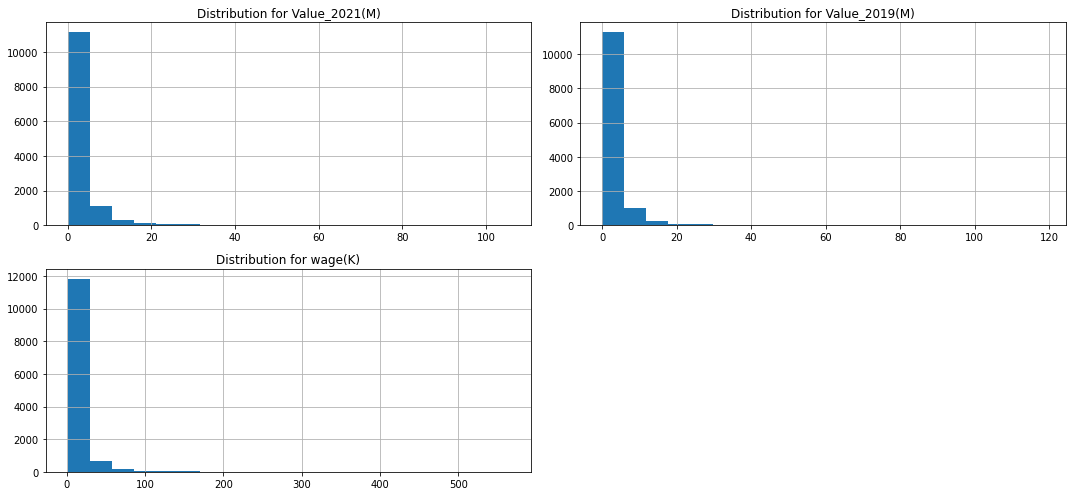

In [38]:
# displaying the histograms for three columns
temp_pd = pd_df[['Value_2021(M)', 'Value_2019(M)', 'wage(K)']]
distribution(temp_pd, 2, 2, 15, 7)

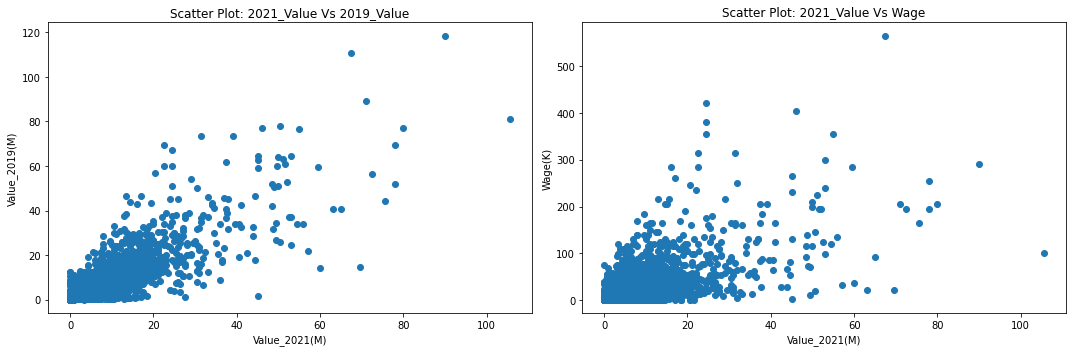

In [39]:
# observing the relationship between players' values in 2021 and players' values in 2019 and also with wage
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
# using first scatter plot for Value_2021 and the second for wage
ax1.scatter(temp_pd['Value_2021(M)'], temp_pd['Value_2019(M)'])
ax2.scatter(temp_pd['Value_2021(M)'], temp_pd['wage(K)'])
ax1.set_xlabel('Value_2021(M)')
ax1.set_ylabel('Value_2019(M)')
ax1.set_title('Scatter Plot: 2021_Value Vs 2019_Value')
ax2.set_xlabel('Value_2021(M)')
ax2.set_ylabel('Wage(K)')
ax2.set_title('Scatter Plot: 2021_Value Vs Wage')
fig.tight_layout()  
plt.show()

It can be seen that both wage and 2019 value exhibit linear relationships with the player values in 2021, but their distributions are not normal but exponential. We now perform log transformation of all three variables because from the distribution of these variables we can see that they are heavily skewed to the right. The reason to transform value_2021(M) is that linear regression expects the response variable to be normally distributed, however, the distribution of our response variable is not normally distributed.

Log Transformation:

In [40]:
from pyspark.sql.functions import log

def log_transformer(col, df):
  for x in col:
    # we will add a tiny fraction 0.01 to every value of the required columns to avoid getting null values as a result of log transformation later
    # we have seen from our data exploration that Value_2019(M) and Value_2021(M) have zero values but not less than zero
    # so we add 0.01 to every value for these two columns
    if (x == 'wage(K)'):
      #regression_df_log = regression_df_log.withColumn(x, F.col(x)-0.99)
      df = df.withColumn('Log_'+x, log(x))
    else:
      df = df.withColumn(x, F.col(x)+0.01)  
      df = df.withColumn('Log_'+x, log(x))
  return df  

col = ['Value_2019(M)', 'wage(K)', 'Value_2021(M)']
regression_df_log = log_transformer(col, regression_df)
regression_df_log.show(5)
regression_df_log.persist()

+--------------------------+--------------------------+--------------------------+--------------------------+-----+-----------------+---+--------------------+-----------+--------------------+------------+--------------+---------------+--------------------+------------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-------------------+------------------+------------------+--------------------+
|Intern

DataFrame[International Reputation_1: int, International Reputation_3: int, International Reputation_5: int, International Reputation_4: int, ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall_2019: int, Potential_2019: int, Club: string, Club Logo: string, Value_2019(M): double, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggre

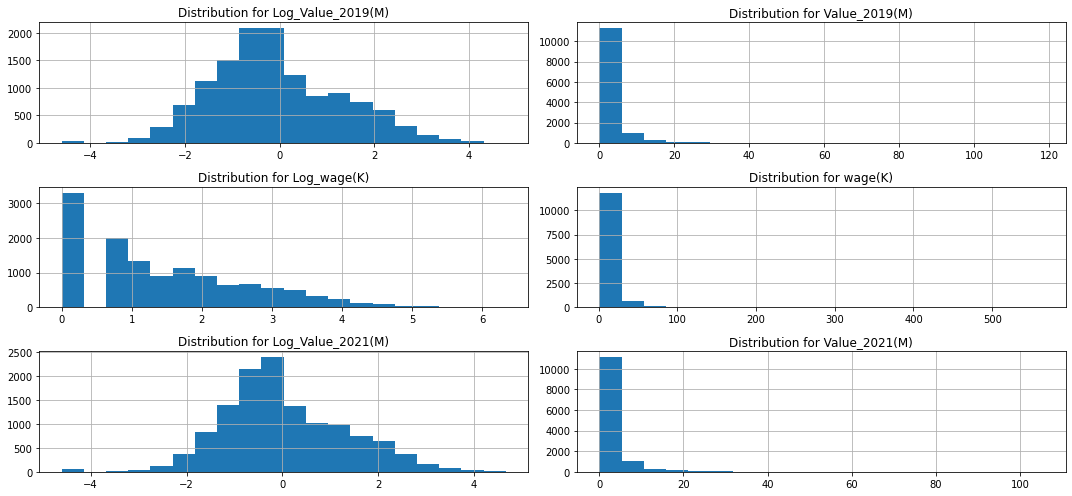

In [41]:
# comparing the distribution of features before and after log transformation
# constructing a pandas dataframe containing the relevant columns
temp_pd_log = regression_df_log[['Log_Value_2019(M)', 'Value_2019(M)', 'Log_wage(K)', 'wage(K)', 'Log_Value_2021(M)', 'Value_2021(M)']].toPandas()
distribution(temp_pd_log, 3, 2, 15, 7)

From the above figure, the charts on the right hand side denote the original distribution for three columns, and the charts on the left hand side denote the distribution after natural log transformation. After performing log transformation, Value_2021(M) and Value_2019(M) are normally distributed but the distribution of wage(K) after transformation is not normally distributed. The log distribution of wage is heavily skewed to the right.

In [42]:
# updating the features_col to include log transformed features and developing a model with these features
features_col_update = ['Log_Value_2019(M)', 'Log_wage(K)', 'International Reputation_1', 'International Reputation_3', 'International Reputation_4', 
                      'International Reputation_5', 'Crossing', 'HeadingAccuracy', 
                      'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'Aggression', 
                      'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking']
train_log = steps_processor(features_col_update, regression_df_log, 'yes')
train_log.persist()

model_lr_log = linear_model(train_log, 'Log_Value_2021(M)')

# training result
performance(model_lr_log)

r2: 0.760183
MAE: 0.432755


After performing log transformation, the r-squared value has increased and the MAE value has decreased significantly.

Next, we will remove features whose p-values are greater than 0.05 and see if we can improve the model performance.

In [43]:
non_significant = []
for feature, p in zip(features_col_update, model_lr_log.summary.pValues):
  if p > 0.05:
    non_significant = non_significant + [feature]

print(non_significant)

['International Reputation_1', 'International Reputation_5', 'HeadingAccuracy', 'Curve', 'LongPassing', 'ShotPower', 'Stamina', 'Positioning', 'Penalties', 'Marking']


In [44]:
# using the significant attributes to build a model
features_col_update_p_values = list(set(features_col_update) - set(non_significant))
train_p = steps_processor(features_col_update_p_values, regression_df_log, 'yes')
train_p.persist()

model_lr_p = linear_model(train_p, 'Log_Value_2021(M)')

# training result
performance(model_lr_p)

r2: 0.759795
MAE: 0.432829


Removing the attributes with p-values greater than 0.05 resulted in a bad performance in terms of both r-squared and MAE.

Validation Data Preprocessing:

In this part, we apply the steps that have been carried out for test data to the validation set.

In [45]:
# moving the module that perfors preprocessing for test or validation set
!mv '/content/FIFA_2019/data_preprocessor_test.py' '/content/'

In [46]:
# creating a regression dataframe from validation data
import data_preprocessor_test

# creating a list containing the variations for different age brackets obtained from the last step
variation_list = [1.725152, 0.545784, -0.032275, -0.170250, -0.260001, 0.000000]

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor_test.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor_test.UnifyValue()
# defining the stage that imputes and removes missing values present in players' values in 2019 and 2021
value_imputation = data_preprocessor_test.ValueImputer(variation_list)
# defining the stage that generates labels based on profits in two years for regression
regression_target = target_generator.ProfitGenerator()

In [47]:
# creating a pipeline to generate dataframe for regression
pipeline_regression = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, regression_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model_test = pipeline_regression.fit(validation_df)
regression_validation_df = pipeline_model_test.transform(validation_df)
regression_validation_df.persist()

# imputing the missing values for wage
regression_validation_df = regression_validation_df.fillna(1, subset=['wage(K)'])
regression_validation_df.persist()

# dummy encoding
regression_validation_df = dummy_encoder(regression_validation_df)
regression_validation_df.persist()

# selecting only those features that have been selected for the training dataset along with removing multicollinear features
# updating the features_col
features_col_update = ['Value_2019(M)', 'wage(K)', 'International Reputation_1', 'International Reputation_3', 'International Reputation_4', 
                      'International Reputation_5', 'Crossing', 'HeadingAccuracy', 
                      'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'Aggression', 
                      'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'Value_2021(M)']

# performing log transformation of three variables
col = ['Value_2019(M)', 'wage(K)', 'Value_2021(M)']
regression_validation_df_log = log_transformer(col, regression_validation_df)
regression_validation_df_log.persist()

# updating the features_col to include log transformed features and developing a model with these features
features_col_update_2 = ['Log_Value_2019(M)', 'Log_wage(K)', 'International Reputation_1', 'International Reputation_3', 'International Reputation_4', 
                      'International Reputation_5', 'Crossing', 'HeadingAccuracy', 
                      'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'Aggression', 
                      'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking']

validation = steps_processor(features_col_update_2, regression_validation_df_log, 'yes')
validation.persist()

DataFrame[features: vector, Log_Value_2021(M): double, Scaled_features: vector]

In [48]:
validation.show()

+--------------------+-------------------+--------------------+
|            features|  Log_Value_2021(M)|     Scaled_features|
+--------------------+-------------------+--------------------+
|[2.74148497718844...| 1.6114359150967734|[2.02240514782189...|
|[0.00995033085316...|-0.8915981192837835|[0.00734040146395...|
|[2.30358459332712...|  1.706564623164823|[1.69936416896431...|
|[0.79299253710600...|  0.412109650826833|[0.58499397318320...|
|[1.16627095199666...|  1.706564623164823|[0.86036305020797...|
|[0.10436003680339...|-1.0936247471570706|[0.07698684377782...|
|[0.83724750389140...| 0.2700271372130602|[0.61764105072993...|
|[1.61143591509677...| 0.7466879474879751|[1.18876314012089...|
|[0.27002710081327...|-0.3078847797693004|[0.19920014272566...|
|[1.50629715351458...| 1.4609379041156563|[1.11120182775598...|
|[1.33762917662319...| 0.5933268452777344|[0.98677474259001...|
|[1.46093794836968...|  0.837247524533702|[1.07774014886681...|
|[0.41210965082683...|-0.673344553263765

Evaluating the validation data using the model built after log transformation.

In [49]:
validation_result = model_lr_log.evaluate(validation)
#print('RMSE on validation data = %g' % validation_result.rootMeanSquaredError)
print('R2 on validation data = %g' % validation_result.r2)
print('MAE on validation data = %g' % validation_result.meanAbsoluteError)

R2 on validation data = 0.764798
MAE on validation data = 0.424725


In our test set, the model's predictibility has improved to 76.35% from 76.14%, but the RMSE error has increased by 0.09 from 2.56 to 2.65. At the same time, our mean absolute error has decreased by around 0.02. Overall, this is neither a bad performance nor huge improvement when the model is used on the test set.

In the previous step, we used hold out validation technique, and estimated the model's performance. In the next step, we use cross validated training set and measure the performance. This is because our dataset is small, and performing holdout validation might not generalise the model. So, we need k-fold cross validation for this purpose and get a clear picture of how the model is going to perform with unseen data.

In [50]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

def cross_validator(training_data, label, parameter_grids=None):
  lr = LinearRegression(featuresCol='Scaled_features', labelCol=label, maxIter=100)
  lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=label, metricName='r2')
  if parameter_grids is None:
    # building a parameter grid with only the default value for linear regression
    grid_lr = ParamGridBuilder().build()
  elif parameter_grids is not None:
    # building a grid of parameters for linear regression to be used by the cross-validation
    grid_lr = ParamGridBuilder()
    for i in parameter_grids:
      # using getattr to call method names dynamically
      grid_lr = grid_lr.addGrid(getattr(lr, i), parameter_grids[i])
    grid_lr = grid_lr.build()
  cv = CrossValidator(estimator=lr, evaluator=lr_evaluator, estimatorParamMaps=grid_lr,\
                      parallelism=2, numFolds=10, seed=2020)
  tuned_model = cv.fit(training_data)
  print('The average R-squared (R2) value from 10 folds is ', tuned_model.avgMetrics[0])
  # transforming the training data using the best model from cross validation
  # in our case, the only model we get from cross validation is our best model. So, putting .bestModel is optional 
  predict_train_lr = tuned_model.bestModel.transform(training_data)
  return tuned_model, predict_train_lr

In [51]:
# obtaining the cross validation result
tuned_model, predict_train = cross_validator(train_log, 'Log_Value_2021(M)')

The average R-squared (R2) value from 10 folds is  0.7580033395953274


In [52]:
from pyspark.ml.evaluation import RegressionEvaluator

def evaluator(model, dataset):
  predict_validation_lr = model.bestModel.transform(dataset)
  lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Log_Value_2021(M)', metricName='mae')
  print('MAE on validation data = %g' % lr_evaluator.evaluate(predict_validation_lr))
  lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Log_Value_2021(M)', metricName='r2')
  print('R2 on validation data = %g' % lr_evaluator.evaluate(predict_validation_lr))
  return predict_validation_lr

# transforming the validation data with the best model from cross validation and printing the performance
predicted_data = evaluator(tuned_model, validation)

MAE on validation data = 0.424725
R2 on validation data = 0.764798


In our results, we can see the performance on the validation set when using hold-out validation and cross validation is same for R2 and MAE. This is because our best model is the only model which have hyperameters same as that of the model used in hold out validation. We use cross validation to see how this model works on the unseen data. From cross validation, we obtained the average R2 value from 10 fold validation as 0.73598 when all the default values for linear regression are used. While from hold out validation we obtained R2 value as 0.74678. This suggest that we got lucky in the hold out validation and cross validation is generalising the model's results. So, we use cross validation for other models.

Generalised Linear Model (GLM):

Our previous model, linear regression, assumes that the response variable is normally distributed and the error distribution of the response variable is also normally distributed. Basically, it tries to capture the linear relationship between predictors and target variable. If there might exist non-linear relationship between predictors and response, then linear regression is not enough to capture the trend. Although, we know that there is a linear relationship between predictors and target variable. Let us see what happens when we fit a generalised linear model. GLM is better if non-linear relationships exists. GLM assumes that the response variable does not have to be normally distributed, but comes from a family of exponential distribution (poisson, normal, binomial, gamma), and the original response variable need not have a linear relationship with the independent variables.

We can only guess that our dataset might have poisson distribution out of other distributions available because for binomial distribution, the response variable should be either O or 1. For gamma, the response variable should be positive, but we have zero for some players' value in 2021. Lastly, normal distribution is already covered by the previous linear regression model. For this, we use the training set obtained after correlation analysis.

In [55]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

glr = GeneralizedLinearRegression(featuresCol='Scaled_features', labelCol='Value_2021(M)', family='poisson',\
                                  link='log', maxIter=100)
glr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='r2')
# building a paramter grid with only the default value for linear regression
grid_glr = ParamGridBuilder().build()
cv_glr = CrossValidator(estimator=glr, evaluator=glr_evaluator, estimatorParamMaps=grid_glr,\
                    parallelism=2, numFolds=10, seed=2020)
model_glr = cv_glr.fit(train_corr)
print('The average R-squared (R2) value from 10 folds is ',model_glr.avgMetrics[0])
# transforming the training data using the best model from cross validation
predict_train_glr = model_glr.bestModel.transform(train_corr)

The average R-squared (R2) value from 10 folds is  0.6343494225627833


From above, it is seen that poisson distribution is not better than normal distribution for our dataset considering the R2 value. 

Hyperparameter Tuning:

In the hyperparameter tuning, we also get to look how ridge and lasson regression works on our dataset through tuning elastic net hyperparameter as elastic net parameter equal to 1 is Lasso and 0 is Ridge and between 0 and 1 is elastic net (combination of Lasso and Ridge)

In [53]:
parameter_grids = {'maxIter': [50, 100, 200, 250, 300], 'regParam': [0.001, 0.01, 0.1, 0, 1, 10], 'elasticNetParam': [0, 0.3, 0.5, 0.8, 1]}
# obtaining the cross validation result
tuned_model, predict_train = cross_validator(train_log, 'Log_Value_2021(M)', parameter_grids)

# transforming the validation data with the best model from cross validation and printing the performance
predicted_data = evaluator(tuned_model, validation)

The average R-squared (R2) value from 10 folds is  0.7580062303223707
MAE on validation data = 0.424767
R2 on validation data = 0.76478


In [54]:
def best_hyperparameter(best_model):
  print('Best Regularisation Parameter:', best_model._java_obj.getRegParam())
  print('Best Elastic Net Parameter:', best_model._java_obj.getElasticNetParam())
  print('Best Max Iteration Parameter:', best_model._java_obj.getMaxIter())

# printing the parameter values for the best estimator
best_hyperparameter(tuned_model.bestModel)

# printing the coefficients and intercept of the best model
print('Coefficients: ' + str(tuned_model.bestModel.coefficients))
print('Intercept: ' + str(tuned_model.bestModel.intercept))

Best Regularisation Parameter: 0.001
Best Elastic Net Parameter: 1.0
Best Max Iteration Parameter: 50
Coefficients: [1.3571419033239498,-0.039458992662957576,0.006462502917962994,0.023975653631287088,0.010212021066231649,0.008675333256058146,-0.020354284012639123,-0.016822530635392404,-0.033087419758223824,0.08221675435642498,0.0,-0.03492844337062128,-0.009254222936037056,-0.08410519709871563,-0.01687048030343021,-0.010208718332567425,-0.020135589384157417,-0.002125743020489307,-0.09311940952311412,-0.03380715189388901,-0.01833753152631737,-0.028737432140347168,-0.011885642707238027,-0.10457969065037187,0.004479265473271791]
Intercept: 2.4999101981060208


In [72]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol='Scaled_features', labelCol='Log_Value_2021(M)', maxIter=100)
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Log_Value_2021(M)', metricName='r2')
# building a grid of parameters for linear regression to be used by the cross-validation
# paramGrid_lr = ParamGridBuilder().addGrid(lr.maxIter, [50, 100, 200, 250, 300])\
# .addGrid(lr.regParam, [0.001, 0.01, 0.1, 0, 1, 10])\
# .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.8, 1]).build()
#paramGrid_lr = ParamGridBuilder().build()
cv = CrossValidator(estimator=lr, evaluator=lr_evaluator, estimatorParamMaps=paramGrid_lr,\
                    parallelism=2, numFolds=2, seed=2020)
tuned_model = cv.fit(train_log)
print('The average R-squared (R2) value from 10 folds is ', tuned_model.avgMetrics[0])

# transforming the training data using the best model from cross validation
# in our case, the only model we get from cross validation is our best model. So, putting .bestModel is optional 
predict_train_lr = tuned_model.bestModel.transform(train_log)

The average R-squared (R2) value from 10 folds is  0.7580033395953274


In [ ]:
parameter_grids = {'maxIter': [50, 100, 200, 250, 300], 'regParam': [0.001, 0.01, 0.1, 0, 1, 10], 'elasticNetParam': [0, 0.3, 0.5, 0.8, 1]}

grid_lr = ParamGridBuilder()
for i in parameter_grids:
  grid_lr = grid_lr.addGrid(getattr(lr, i), parameter_grids[i])
grid_lr = grid_lr.build()
grid_lr
#'maxIter': [50, 100, 200, 250, 300], 'regParam': [0.001, 0.01, 0.1, 0, 1, 10], 'elasticNetParam': [0, 0.3, 0.5, 0.8, 1]}

In [71]:
print(best_reg_param, best_elasticnet_param, best_iter)

0.0 0.0 100


In [ ]:
# transforming the validation data with the best model from cross validation
predict_validation_lr = model_lr.bestModel.transform(validation)
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='mae')
print('MAE on validation data = %g' % lr_evaluator.evaluate(predict_validation_lr))
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='r2')
print('R2 on validation data = %g' % lr_evaluator.evaluate(predict_validation_lr))

Compared to ordinary regression and ridge regression, the MAE has improved while RMSE has worsen a bit at alpha = 0.3. This may be due to the fact that RMSE penalises large error differences caused by anomalies. If we don't like large error differences caused by anomalies then we should use RMSE or if we don't care about large difference MAE is suitable. 